# Dogs vs Cats image Classification (without image Augmentation)

One concept to be covered is
1. Building data input pipelines fromm the `tf.keraspreprocessing.image.ImageDataGenerator` class -- How we can efficiently work wiyh data on disk to efficiently interface our model

2. Overfitting -what is it ? and how to identify it

In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [5]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cat_and_dogs_filtered.zip', origin= _URL, extract = True)

68606236/68606236 [==============================] - 0s 0us/step


The dataset we have downloaded has the following directory structure.

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ...]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ...]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

We can list the directories with the following terminal command:

In [6]:
# We want to get the zip directory where the zip_dir was saved and get the file
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs


We will now assign the variables with the proper file path with the training and test datasets

In [7]:
# We want to join each directory with theirsubdirectories to form a classified directory
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')


# From there lets now split for cats and dogs
train_cats_dir = os.path.join(train_dir, 'cats') # train directory with dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # train directory with dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Validation directory with cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs') # Validation directory with dog pictures

# Understanding our data
Lets look at how many cats and dogs that is in our train and validation data

In [8]:
# To know the total number of cats and dogs
num_cats_train = len(os.listdir(train_cats_dir))
num_dogs_train = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_train + num_dogs_train
total_val = num_cats_val + num_dogs_val

In [9]:
# Number of training images for cats and dogs
print(f"Numbers of training cats images : {num_cats_train}")
print(f"Numbers of training dogs images : {num_dogs_train}")

# Number of valldation images for cats and dogs
print(f"Numbers of validation cats images : {num_cats_val}")
print(f"Numbers of validation dogs images : {num_dogs_val}")

# The total number of train and validation
print(f"Total numbers of training images : {total_train}")
print(f"Total number of validation images : {total_val}")

Numbers of training cats images : 1000
Numbers of training dogs images : 1000
Numbers of validation cats images : 500
Numbers of validation dogs images : 500
Total numbers of training images : 2000
Total number of validation images : 1000


# Selesting model parameters

In [10]:
BATCH_SIZE = 100 # Number of training examples to process before updating our models variables
IMAGE_SHAPE = 150 # Our training data consists of images with width of 150 pixels and height of 150 pixels

# Preprocess our data
To preprocess our data, we have to do several things, among them are
1. Read images from disc
2. Decode the images from disc and convert them into proper grid fprmat as per their RGB content
3. Convert them into floating pont tensors
4. Rescale the tensors

Luckily they could be done with the `tf.keras.preprocessing.Image.imageDataDenerator`

In [11]:
train_image_generator = ImageDataGenerator(rescale = 1./255)
validation_image_generator = ImageDataGenerator(rescale = 1./255)

After defining our generators for training and validation images, flow_from_directory method will load images from the disk, apply rescaling, and resize them using single line of code.

In [12]:
train_data_gen = train_image_generator.flow_from_directory(batch_size = BATCH_SIZE,
                                                          directory = train_dir,
                                                          shuffle = True,
                                                          target_size = (IMAGE_SHAPE, IMAGE_SHAPE), #(150,150)
                                                          class_mode = 'binary')

Found 2000 images belonging to 2 classes.


In [13]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size = BATCH_SIZE,
                                                          directory = validation_dir,
                                                          shuffle = False,
                                                          target_size = (IMAGE_SHAPE, IMAGE_SHAPE), #(150,150)
                                                          class_mode = 'binary')

Found 1000 images belonging to 2 classes.


# Visuaizing training images

In [14]:
sample_training_images, _ = next(train_data_gen)

In [15]:
# This will plot the images in form of grid in 1 column and 5 rows where images are placed in each column

def plotImages(image_arr):
  fig, axes = plt.subplots(1, 5, figsize = (20, 20))
  axes = axes.flatten()

  for img, ax in zip(image_arr, axes):
    ax.imshow(img)
  plt.tight_layout()
  plt.show()

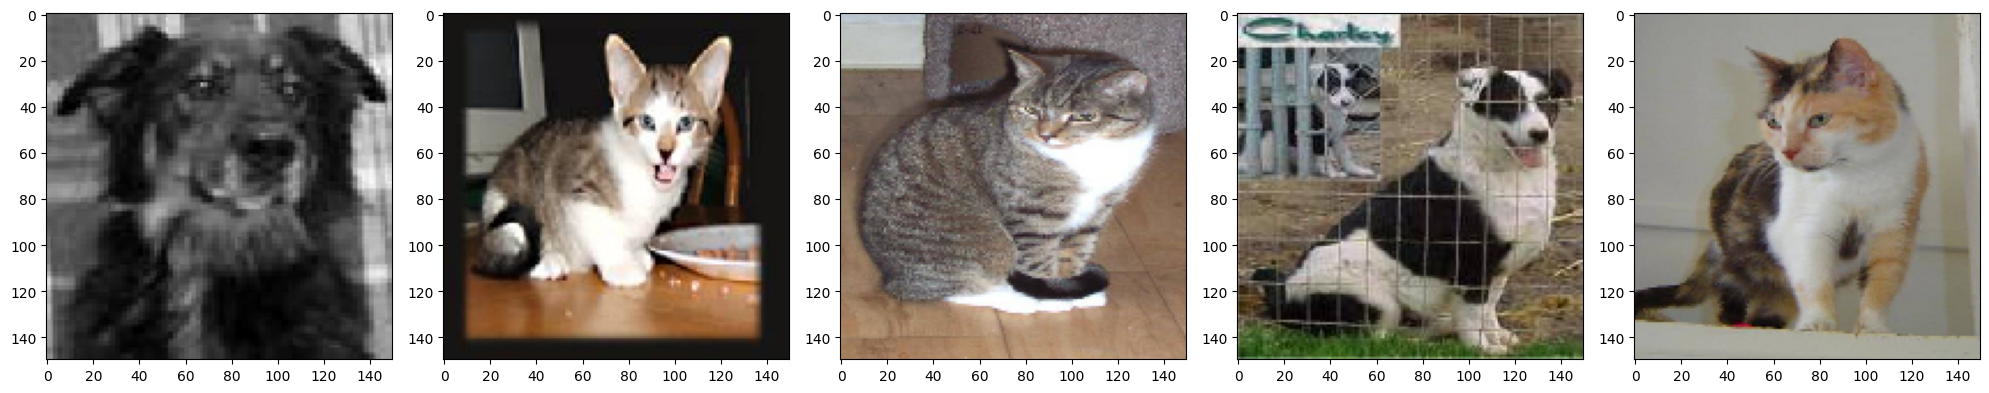

In [16]:
plotImages(sample_training_images[:5])

# Model Creation

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPool2D((2, 2), strides= 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPool2D((2, 2), strides= 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPool2D((2, 2), strides= 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPool2D((2, 2), strides= 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),

    tf.keras.layers.Dense(2, activation = 'softmax')
])

# Compile The Model

In [18]:
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer= 'adam',
    metrics = ['accuracy']
)

# Train The Model

In [24]:
import math
EPOCH = 20

history = model.fit_generator(train_data_gen, epochs = EPOCH,
                              steps_per_epoch = int(np.ceil(total_train/float(BATCH_SIZE))),
                              validation_data= val_data_gen,
                              validation_steps= int(np.ceil(total_val/ float(BATCH_SIZE))))

<ipython-input-24-3ac703804dd1>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_data_gen, epochs = EPOCH,


Epoch 1/20
20/20 [==============================] - 11s 553ms/step - loss: 0.0667 - accuracy: 0.9745 - val_loss: 1.0333 - val_accuracy: 0.7380
Epoch 2/20
20/20 [==============================] - 7s 339ms/step - loss: 0.0486 - accuracy: 0.9840 - val_loss: 1.2066 - val_accuracy: 0.7260
Epoch 3/20
20/20 [==============================] - 6s 305ms/step - loss: 0.0224 - accuracy: 0.9955 - val_loss: 1.3091 - val_accuracy: 0.7260
Epoch 4/20
20/20 [==============================] - 5s 229ms/step - loss: 0.0125 - accuracy: 0.9975 - val_loss: 1.4668 - val_accuracy: 0.7390
Epoch 5/20
20/20 [==============================] - 6s 281ms/step - loss: 0.0076 - accuracy: 0.9995 - val_loss: 1.5340 - val_accuracy: 0.7380
Epoch 6/20
20/20 [==============================] - 5s 236ms/step - loss: 0.0049 - accuracy: 0.9995 - val_loss: 1.5067 - val_accuracy: 0.7450
Epoch 7/20
20/20 [==============================] - 6s 290ms/step - loss: 0.0055 - accuracy: 0.9985 - val_loss: 1.5480 - val_accuracy: 0.7510
Epoch

# Model Summary

In [ ]:
model.summary()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCH)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

In [ ]:
range(EPOCH)

In [ ]:
history.history['accuracy']